In [30]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter

In [31]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [32]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,text,Column,Integer,String,Float,MetaData,inspect,desc
from sqlalchemy.ext.declarative import declarative_base
from datetime import datetime, timedelta

In [33]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [34]:
# reflect an existing database into a new model
# reflect the tables

Base = automap_base()
Base.prepare(autoload_with=engine)


In [35]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [36]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [37]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [38]:
# Display the columns for the measurement table.
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [39]:
# Find the most recent date in the data set.
most_recent_record = session.query(measurement).order_by(func.datetime(measurement.date).desc()).first()
most_recent_record.date


'2017-08-23'

            date  precipitation_Score
0     2016-08-23                 0.00
1009  2016-08-23                  NaN
1529  2016-08-23                 1.79
704   2016-08-23                 0.05
361   2016-08-23                 0.15
...          ...                  ...
1527  2017-08-22                 0.00
1008  2017-08-23                 0.00
360   2017-08-23                 0.00
1528  2017-08-23                 0.08
2229  2017-08-23                 0.45

[2230 rows x 2 columns]


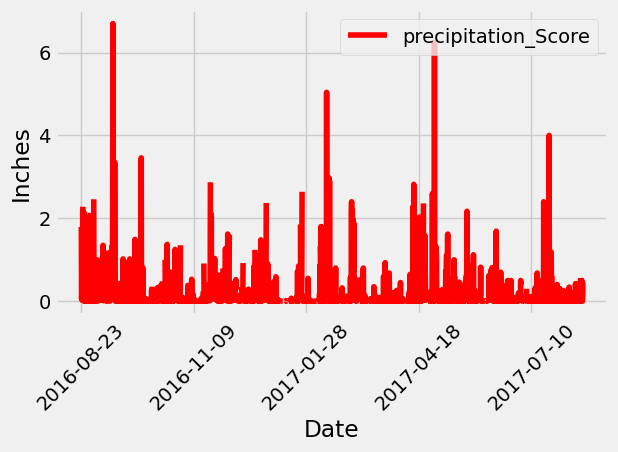

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = datetime.strptime(most_recent_record.date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
date_1_year_ago = most_recent_date - timedelta(days=365)
date_1_year_ago

# Perform a query to retrieve the data and precipitation scores
last_1_year_records = session.query(measurement).filter(
        func.datetime(measurement.date) >= date_1_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names

precip_data = {'date' :[],'precipitation_Score':[]}
# convert the records to dataframe
for record in last_1_year_records:
    precip_data['date'].append(record.date)
    precip_data['precipitation_Score'].append(record.prcp)

precip_df = pd.DataFrame(precip_data)

# Sort the dataframe by date
precip_df_sorted = precip_df.sort_values(by='date')
print(precip_df_sorted)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df_sorted.plot(x='date', y='precipitation_Score', rot=45, color='red')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [41]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats_prcp = precip_df_sorted.describe()
summary_stats_prcp

,precipitation_Score
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [42]:
# Display the columns for the station table.
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [43]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station).count()
station_count

9

In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station, 
       func.count(measurement.id).label('count'), 
       ]
station_id_count = session.query(*sel).\
     group_by(measurement.station).\
    order_by(desc('count')).all()
station_id_count



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [measurement.station,  
       func.min(measurement.tobs), 
       func.max(measurement.tobs),
       func.avg(measurement.tobs),
      ]
station_stats = session.query(*sel).\
    filter( measurement.station == "USC00519281").all()
   
station_stats

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [46]:
most_active_record = session.query(measurement).filter(measurement.station == 'USC00519281').order_by(func.datetime(measurement.date).desc()).first()
most_active_record.date

'2017-08-18'

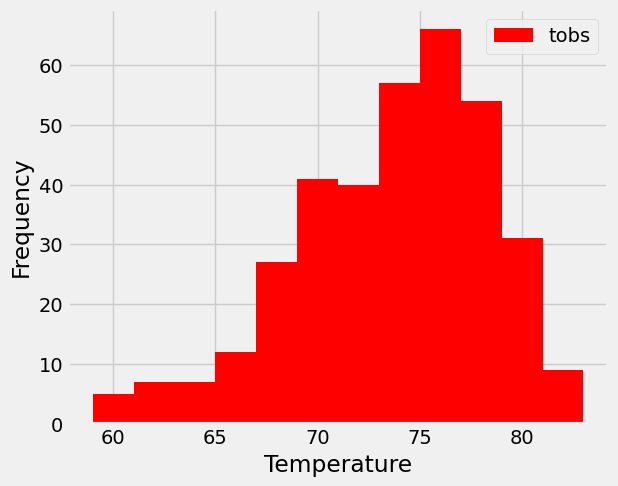

In [49]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_record = session.query(measurement).filter(measurement.station == 'USC00519281').order_by(func.datetime(measurement.date).desc()).first()
most_active_record.date
most_active_date = datetime.strptime(most_active_record.date, '%Y-%m-%d')

date_1_year_ago = most_active_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
last_1_year_tobs = session.query(measurement.tobs).\
     filter(measurement.station == 'USC00519281').\
     filter(func.datetime(measurement.date) >= date_1_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
tobs_df = pd.DataFrame(last_1_year_tobs,columns=['tobs'])

tobs_df.plot.hist(bins=12,color='red')
plt.tight_layout()
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.show()

# Close Session

In [48]:
# Close Session
session.close()